In [1]:
import keras
import gc

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data = np.load(r'C:\Users\dpetr\Desktop\sxoli\Level 3\Individual\datasets\GTZAN\features.npz')
labels = data['labels']

In [3]:
mel = data['mel']
print(mel.shape, mel.dtype, labels.shape, labels.dtype)

(9986, 128, 130) float32 (9986,) int32


In [4]:
mfcc = data['mfcc']
print(mfcc.shape, mfcc.dtype, labels.shape, labels.dtype)

(9986, 20, 130) float32 (9986,) int32


In [5]:
def prepare_datasets(x, y, test_size, validation_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size, stratify=y_train)
    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    return x_train, x_test, x_validation, y_train, y_test, y_validation

x_train, x_test, x_validation, y_train, y_test, y_validation = prepare_datasets(mfcc, labels, test_size=1500, validation_size=1500)

In [6]:
print("X shape: ", x_train.shape, x_validation.shape, x_test.shape)
print("Y shape: ", y_train.shape, y_validation.shape, y_test.shape)

X shape:  (6986, 20, 130, 1) (1500, 20, 130, 1) (1500, 20, 130, 1)
Y shape:  (6986,) (1500,) (1500,)


In [7]:
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
x_validation = (x_validation - mean) / std

In [8]:
def build_mel_model(input_shape):

    #create model
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((3,3), strides=(3,3), padding='valid'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
    model.add(keras.layers.Dropout(0.65))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [13]:
def build_mfcc_model(input_shape):

    #create model
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(0.00005)))
    model.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='valid'))
    model.add(keras.layers.BatchNormalization(momentum=0.98))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)))
    model.add(keras.layers.Dropout(0.65))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [14]:
input_shape = x_train[0].shape
model = build_mfcc_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.00002)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 64, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 64, 64)        256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 9, 64, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 62, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 31, 128)       0

Epoch 1/55
219/219 [==============================] - 5s 17ms/step - loss: 2.2787 - accuracy: 0.1894 - val_loss: 2.1912 - val_accuracy: 0.2700
Epoch 2/55
219/219 [==============================] - 3s 15ms/step - loss: 1.9190 - accuracy: 0.3368 - val_loss: 1.6781 - val_accuracy: 0.4853
Epoch 3/55
219/219 [==============================] - 3s 15ms/step - loss: 1.7747 - accuracy: 0.4027 - val_loss: 1.5423 - val_accuracy: 0.5313
Epoch 4/55
219/219 [==============================] - 3s 15ms/step - loss: 1.6799 - accuracy: 0.4363 - val_loss: 1.4482 - val_accuracy: 0.5487
Epoch 5/55
219/219 [==============================] - 3s 15ms/step - loss: 1.5962 - accuracy: 0.4636 - val_loss: 1.3907 - val_accuracy: 0.5720
Epoch 6/55
219/219 [==============================] - 3s 15ms/step - loss: 1.5185 - accuracy: 0.4933 - val_loss: 1.3246 - val_accuracy: 0.5913
Epoch 7/55
219/219 [==============================] - 3s 15ms/step - loss: 1.4746 - accuracy: 0.5104 - val_loss: 1.2740 - val_accuracy: 0.6060

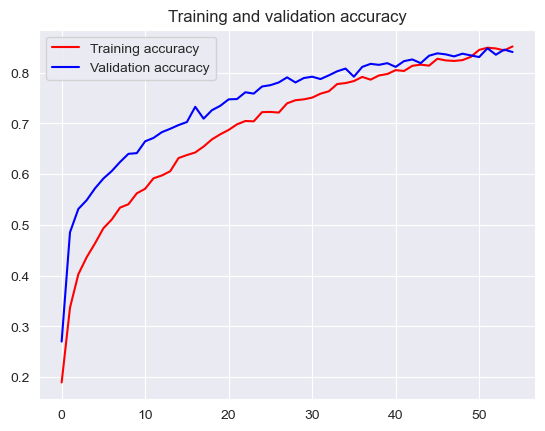

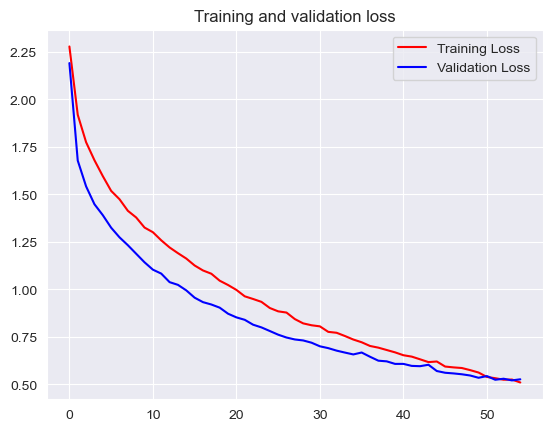

Accuracy on test set is:0.8386666774749756


In [16]:
history = model.fit(x_train, y_train,
                    validation_data=(x_validation, y_validation),
                    epochs=55,
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=3,
                                                                verbose=1,
                                                                restore_best_weights=True)]
                    )

test_error, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Accuracy on test set is:{}".format(test_accuracy))

In [12]:
del model
keras.backend.clear_session()
gc.collect()

8081